<a href="https://colab.research.google.com/github/nelsooooon/BFDLFinal/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Intel-Image-Classification]
- **Nama:** Nelson Ahli
- **Email:** ahlinelson04@gmail.com | m320d5y1490@student.devacademy.id
- **ID Dicoding:** M320D5Y1490

## Import Semua Packages/Library yang Digunakan

In [17]:
from google.colab import files
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

import cv2
import random
from skimage import img_as_ubyte, io
from skimage.exposure import adjust_gamma
from skimage.transform import rotate, AffineTransform, warp

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm as tq

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import keras_tuner as kt

## Data Preparation

### Data Loading

In [39]:
files.upload()
print("Success")

Saving kaggle.json to kaggle (2).json
Success


In [40]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
# Membuat path directory
train_dir = "seg_train/seg_train/"
test_dir = "seg_test/seg_test/"
val_dir = "seg_pred/seg_pred/"

combined_dir = "dataset/"

In [ ]:
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Menggabungkan seluruh dataset jadi satu
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [ ]:
# Fungsi untuk mengecek resolusi gambar
def print_images_resolution(dataset):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(dataset):
        subdir_path = os.path.join(dataset, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")

        print("---------------")

    print(f"\nTotal: {total_images}")

In [ ]:
print_images_resolution(combined_dir)

glacier: 2957
- (150, 146)
- (150, 120)
- (150, 149)
- (150, 110)
- (150, 123)
- (150, 142)
- (150, 119)
- (150, 97)
- (150, 135)
- (150, 76)
- (150, 150)
- (150, 134)
- (150, 105)
- (150, 102)
- (150, 143)
- (150, 111)
- (150, 72)
---------------
buildings: 2628
- (150, 146)
- (150, 120)
- (150, 149)
- (150, 110)
- (150, 123)
- (150, 142)
- (150, 119)
- (150, 97)
- (150, 135)
- (150, 76)
- (150, 150)
- (150, 134)
- (150, 105)
- (150, 102)
- (150, 124)
- (150, 143)
- (150, 111)
- (150, 72)
---------------
forest: 2745
- (150, 136)
- (150, 142)
- (150, 105)
- (150, 102)
- (150, 108)
- (150, 111)
- (150, 120)
- (150, 123)
- (150, 135)
- (150, 141)
- (150, 150)
- (150, 110)
- (150, 113)
- (150, 119)
- (150, 76)
- (150, 134)
- (150, 143)
- (150, 146)
- (150, 149)
- (150, 97)
- (150, 115)
- (150, 124)
- (150, 133)
- (150, 72)
---------------
street: 2883
- (150, 136)
- (150, 142)
- (150, 105)
- (150, 102)
- (150, 108)
- (150, 111)
- (150, 120)
- (150, 123)
- (150, 135)
- (150, 141)
- (150, 

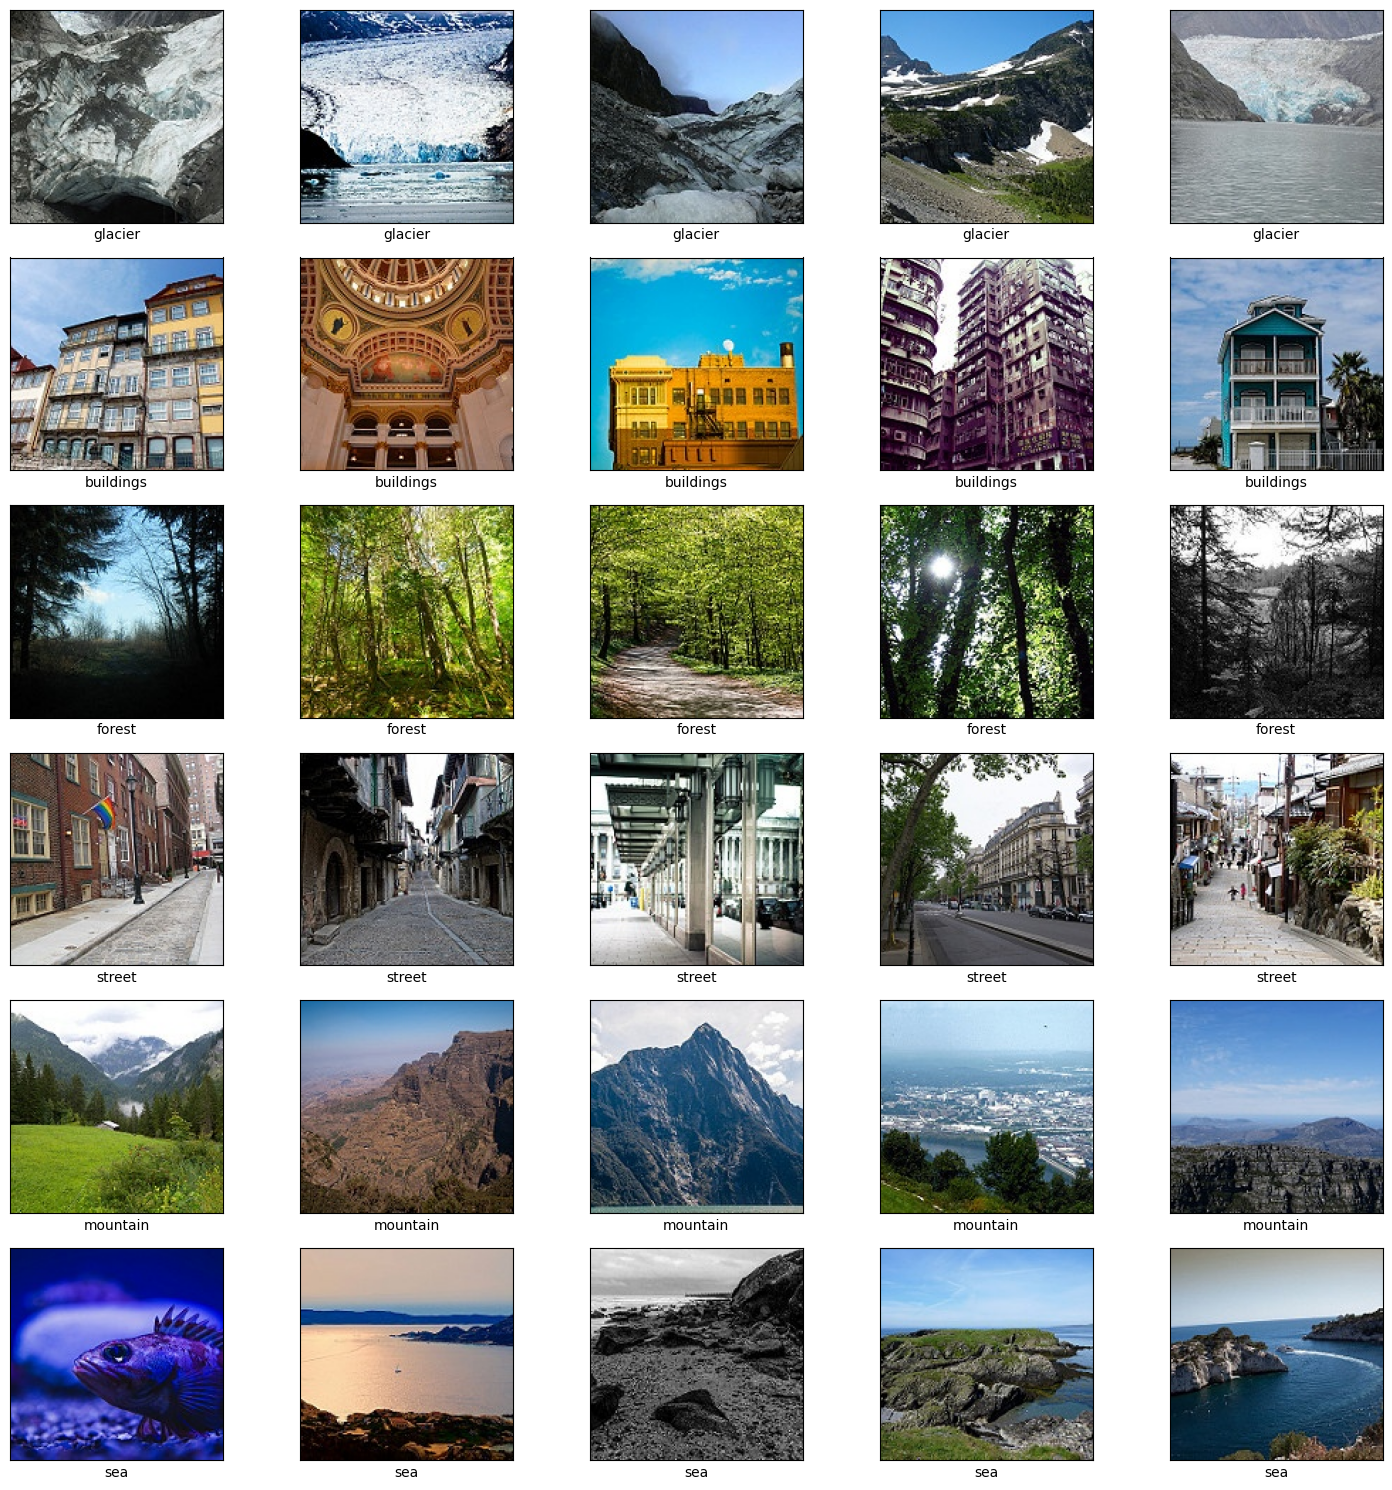

In [ ]:
# Menampilkan sample gambar
seg_image = {}

for i in os.listdir(combined_dir):
    seg_image[i] = os.listdir(os.path.join(combined_dir, i))

fig, axs = plt.subplots(len(seg_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(combined_dir)):
    images = np.random.choice(seg_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(combined_dir, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

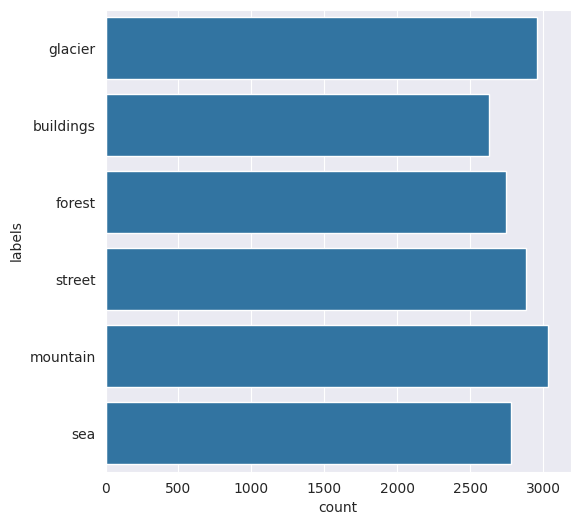

In [ ]:
# Menampilkan jumlah gambar sebelum preprocessing
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(combined_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

In [ ]:
# Fungsi preprocessing
def anticlockwise_rotation(img):
    sudut = random.randint(0,10)
    return rotate(img, sudut, mode="edge")

def clockwise_rotation(img):
    sudut = random.randint(0,10)
    return rotate(img, -sudut, mode="edge")

def flip_horizontal(img):
    return np.fliplr(img)

def add_brightness(img):
    gamma = random.uniform(0.5, 1.5)
    return adjust_gamma(img, gamma=gamma, gain=1)

def blur_image(img):
    return cv2.GaussianBlur(img, (3,3),0)

def sheared(img):
    shear = random.uniform(-0.2, 0.2)
    transform = AffineTransform(shear=shear)
    return warp(img, transform, mode="edge")

def warp_shift(img):
    translation = (random.randint(0,40),random.randint(0,40))
    transform = AffineTransform(translation=translation)
    return warp(img, transform, mode="edge")

In [ ]:
# Menerapkan preprocessing oversampling
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_horizontal,
                    'shear image': sheared
                  }

class_to_oversample = ["street", "sea"]

for i, class_name in enumerate(os.listdir(combined_dir)):
    img_path = os.path.join(combined_dir, class_name)

    if class_name not in class_to_oversample:
       continue

    images = []
    for im in os.listdir(img_path):
        if not im.startswith("augmented_image_"):
           images.append(os.path.join(img_path,im))

    images_to_generate = 200
    j = 1

    while j <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)
            transformed_image = cv2.resize(original_image, (150,150))
            transformation_count = random.randint(1, len(transformations))

            key = random.choice(list(transformations))
            transformed_image = transformations[key](transformed_image)

            new_image_path = "%s/augmented_image_%s.jpg" %(img_path, j)
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            j += 1
        except ValueError as e:
            print('could not read the', image , ':', e, 'hence skipping it.')

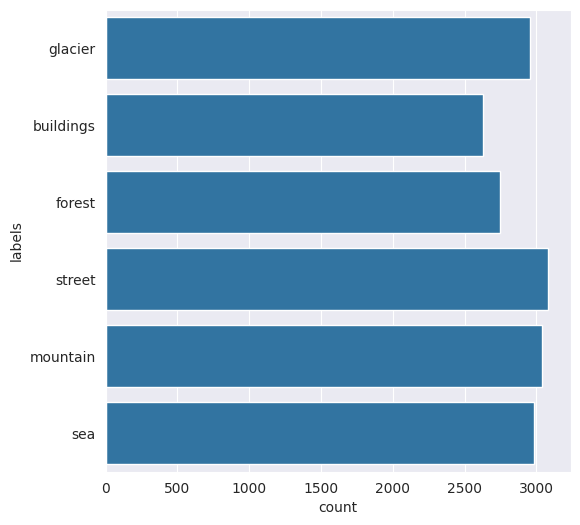

In [ ]:
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(combined_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [ ]:
# Membuat df dari dataset
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(combined_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

labels
buildings    2628
forest       2745
glacier      2957
mountain     3037
sea          2984
street       3083
dtype: int64

In [ ]:
# Melakukan train_test_split pada df
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [ ]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Melihat sample df
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))


set    labels   
test   buildings     485
       forest        593
       glacier       562
       mountain      612
       sea           608
       street        627
train  buildings    2143
       forest       2152
       glacier      2395
       mountain     2425
       sea          2376
       street       2456
dtype: int64 


                             path     labels    set
2757        dataset/sea/17216.jpg        sea  train
16589       dataset/sea/13044.jpg        sea   test
11915  dataset/buildings/3831.jpg  buildings  train
4020         dataset/sea/4626.jpg        sea  train
3428        dataset/sea/17564.jpg        sea  train


In [ ]:
# Membuat path directory dataset final
datasource_path = "dataset/"
dataset_path = "Dataset-Final/"

In [ ]:
# Menyimpan df yang sudah di train_test_split ke dalam dataset final
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
       file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
       os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
       shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

In [9]:
# Membuat path directory train dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

for i, class_name in enumerate(os.listdir(TRAIN_DIR)):
    train_path = os.path.join(TRAIN_DIR, class_name)
    print(f"Total number of {class_name} images in training set: ",len(os.listdir(train_path)))

print("============================================================")

for i, class_name in enumerate(os.listdir(TEST_DIR)):
    test_path = os.path.join(TEST_DIR, class_name)
    print(f"Total number of {class_name} images in test set: ",len(os.listdir(test_path)))

Total number of glacier images in training set:  2395
Total number of buildings images in training set:  2143
Total number of forest images in training set:  2152
Total number of street images in training set:  2456
Total number of mountain images in training set:  2425
Total number of sea images in training set:  2376
Total number of glacier images in test set:  562
Total number of buildings images in test set:  485
Total number of forest images in test set:  593
Total number of street images in test set:  627
Total number of mountain images in test set:  612
Total number of sea images in test set:  608


In [3]:
# Membuat generator untuk model CNN
classes = ['glacier', 'sea', 'street']

# Membuat ImageDataGenerator dengan data augmentation untuk train
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split = 0.2)

# Membuat ImageDataGenerator tanpa data augmentation untuk test
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=64,
                                              target_size=(128,128),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              classes=classes,
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=64,
                                                   target_size=(128,128),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   classes=classes,
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(128,128),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  classes=classes,
                                                  shuffle=False)

Found 5782 images belonging to 3 classes.
Found 1445 images belonging to 3 classes.
Found 1797 images belonging to 3 classes.


In [4]:
tf.keras.backend.clear_session()

# Fungsi build model CNN
def cnn_model(hp):
    model = Sequential()
    model.add(InputLayer(shape=(128, 128, 1)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPool2D((2, 2)))

    model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPool2D((2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPool2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [5]:
model = cnn_model(None)
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,298,435 (16.40 MB)

 Trainable params: 4,297,987 (16.40 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [6]:
# Membuat parameter untuk fitting model
epochs = 100
fine_tuning = [ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min'),
               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)]

In [7]:
# Melakukan fitting model CNN
%time

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=fine_tuning)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.58 µs


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 65s 456ms/step - accuracy: 0.5005 - loss: 2.8037 - val_accuracy: 0.3156 - val_loss: 1.9332 - learning_rate: 0.0010
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.6072 - loss: 0.8365 - val_accuracy: 0.3287 - val_loss: 1.4209 - learning_rate: 0.0010
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.6824 - loss: 0.7114 - val_accuracy: 0.3647 - val_loss: 2.0974 - learning_rate: 0.0010
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.6967 - loss: 0.6719 - val_accuracy: 0.4394 - val_loss: 1.3848 - learning_rate: 0.0010
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.7359 - loss: 0.6099 - val_accuracy: 0.3682 - val_loss: 2.5869 - learning_rate: 0.0010
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7559 - loss: 0.5823 - val_accuracy: 0.6955 - val_loss: 0.6461 - learning_rate: 0.0010
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.7678 - l

In [11]:
# Membuat generator untuk transfer learning MobileNet
classes = ['glacier', 'sea', 'street']

# Membuat ImageDataGenerator dengan data augmentation untuk train
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split = 0.2)

# Membuat ImageDataGenerator tanpa data augmentation untuk test
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=64,
                                              target_size=(128,128),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              classes=classes,
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=64,
                                                   target_size=(128,128),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   classes=classes,
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(128,128),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  classes=classes,
                                                  shuffle=False)

Found 5782 images belonging to 3 classes.
Found 1445 images belonging to 3 classes.
Found 1797 images belonging to 3 classes.


In [16]:
tf.keras.backend.clear_session()

# Fungsi transfer learning model MobileNet
def mobilenet_model():
    mobilenet_base = MobileNetV2(weights='imagenet',
                                 include_top=False,
                                 input_shape=(128,128,3))

    mobilenet_base.trainable = False
    print(f"Total MobileNet layers: {len(mobilenet_base.layers)}")
    print(f"Trainable MobileNet layers: {sum(1 for l in mobilenet_base.layers if l.trainable)}")

    model = Sequential([mobilenet_base,
                        Conv2D(32, (3, 3), activation='relu', padding='same'),
                        MaxPooling2D(pool_size=(2,2)),
                        BatchNormalization(),
                        Flatten(),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(3, activation='softmax')])

    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [17]:
mobilenet = mobilenet_model()
print(mobilenet.summary())

Total MobileNet layers: 154
Trainable MobileNet layers: 0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 4, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,660,579 (10.15 MB)

 Trainable params: 402,531 (1.54 MB)

 Non-trainable params: 2,258,048 (8.61 MB)

None


In [18]:
# Membuat parameter untuk fitting model
epochs = 50
fine_tuning = [ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min'),
               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)]

In [19]:
%time

# Melakukan fitting model MobileNet
history_mobilenet = mobilenet.fit(train_generator,
                                  epochs=epochs,
                                  validation_data=validation_generator,
                                  callbacks=fine_tuning)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 20.5 µs


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 108s 826ms/step - accuracy: 0.8307 - loss: 0.4209 - val_accuracy: 0.9308 - val_loss: 0.2086 - learning_rate: 0.0010
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 321ms/step - accuracy: 0.9341 - loss: 0.1847 - val_accuracy: 0.9343 - val_loss: 0.1771 - learning_rate: 0.0010
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 316ms/step - accuracy: 0.9391 - loss: 0.1637 - val_accuracy: 0.9412 - val_loss: 0.1800 - learning_rate: 0.0010
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 297ms/step - accuracy: 0.9430 - loss: 0.1522 - val_accuracy: 0.9419 - val_loss: 0.1826 - learning_rate: 0.0010
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9492 - loss: 0.1406
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 303ms/step - accuracy: 0.9492 - loss: 0.1406 - val_accuracy: 0.9419 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 321ms/step - accuracy: 0.9536 - loss: 0.1

## Evaluasi dan Visualisasi

In [8]:
# Evaluasi model CNN
evaluation = model.evaluate(test_generator)

print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.9046 - loss: 0.2569
Loss: 0.2182576209306717
Accuracy: 0.9220923781394958


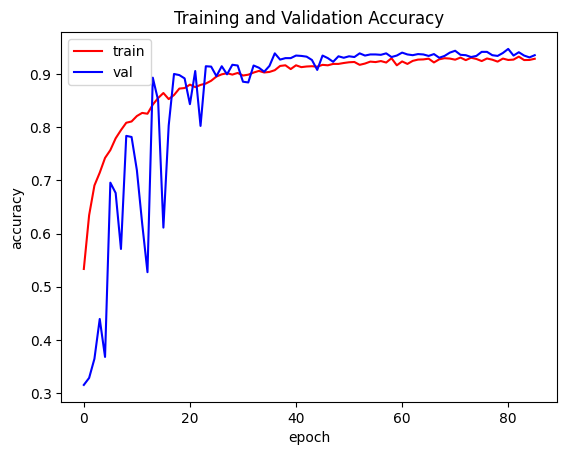

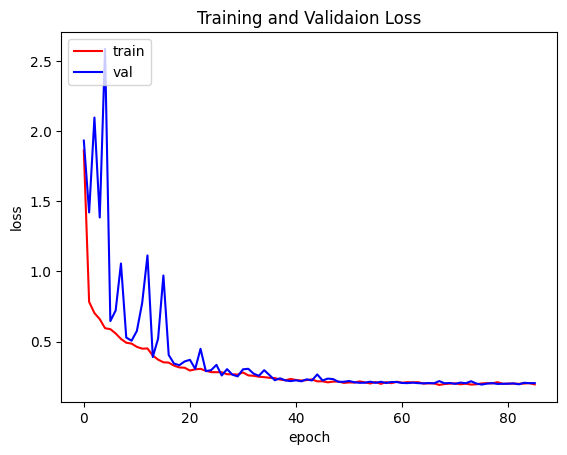

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_graph = range(len(acc))

plt.plot(epochs_graph, acc, 'r')
plt.plot(epochs_graph, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs_graph, loss, 'r')
plt.plot(epochs_graph, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step
==== CNN ====
Accuracy: 0.9221
Precision: 0.9222
Recall: 0.9221
F1-Score: 0.9220

----------------------------------------



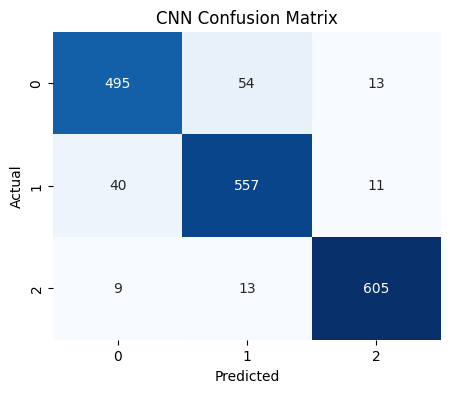


----------------------------------------



In [10]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print("==== CNN ====")
print(f"Accuracy: {accuracy_score(test_generator.classes, y_pred):.4f}")
print(f"Precision: {precision_score(test_generator.classes, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(test_generator.classes, y_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(test_generator.classes, y_pred, average='weighted'):.4f}")

print("\n" + "-"*40 + "\n")

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n" + "-"*40 + "\n")

In [20]:
# Evaluasi model MobileNet
evaluation = mobilenet.evaluate(test_generator)

print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 356ms/step - accuracy: 0.9636 - loss: 0.1117
Loss: 0.08591556549072266
Accuracy: 0.9727323055267334


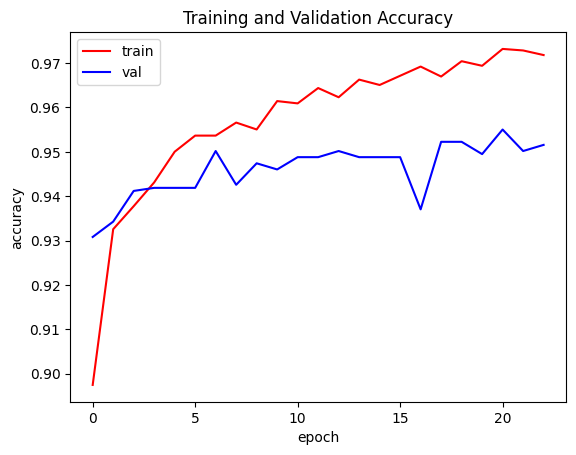

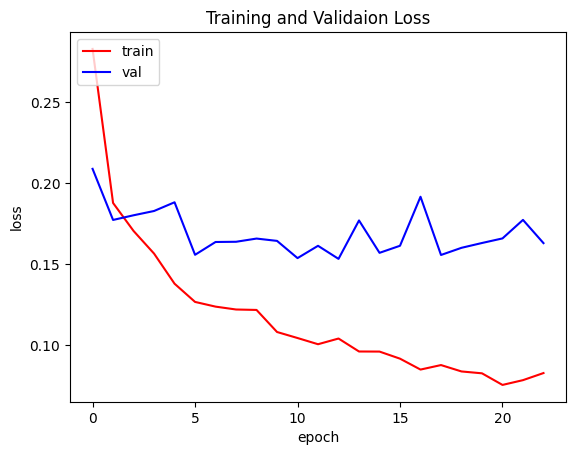

In [21]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs_graph = range(len(acc))

plt.plot(epochs_graph, acc, 'r')
plt.plot(epochs_graph, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs_graph, loss, 'r')
plt.plot(epochs_graph, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step
==== MobileNet ====
Accuracy: 0.9727
Precision: 0.9727
Recall: 0.9727
F1-Score: 0.9727

----------------------------------------



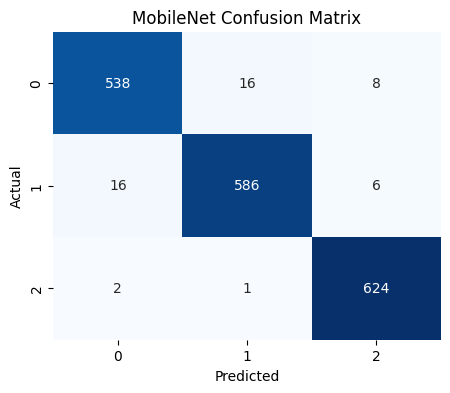


----------------------------------------



In [22]:
y_mn = mobilenet.predict(test_generator)
y_mn = np.argmax(y_mn, axis=1)

cm_mn = confusion_matrix(test_generator.classes, y_mn)

print("==== MobileNet ====")
print(f"Accuracy: {accuracy_score(test_generator.classes, y_mn):.4f}")
print(f"Precision: {precision_score(test_generator.classes, y_mn, average='weighted'):.4f}")
print(f"Recall: {recall_score(test_generator.classes, y_mn, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(test_generator.classes, y_mn, average='weighted'):.4f}")

print("\n" + "-"*40 + "\n")

plt.figure(figsize=(5, 4))
sns.heatmap(cm_mn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('MobileNet Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n" + "-"*40 + "\n")

### Hyperparameter Tuning


In [12]:
# Menerapkan Hyperparameter Tuning Random Search pada model CNN
tuner = kt.RandomSearch(cnn_model,
                        objective="val_accuracy",
                        max_trials=50,
                        directory="kt_dir",
                        project_name="bfdl_akhir",
                        overwrite=True)

tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=epochs,
             callbacks=fine_tuning,
             verbose=2)

best_model_random = tuner.get_best_models(num_models=1)[0]

Trial 1 Complete [00h 17m 33s]
val_accuracy: 0.9391003251075745

Best val_accuracy So Far: 0.9391003251075745
Total elapsed time: 00h 17m 33s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
==== CNN Random Search ====
Accuracy: 0.9277
Precision: 0.9276
Recall: 0.9277
F1-Score: 0.9276

----------------------------------------



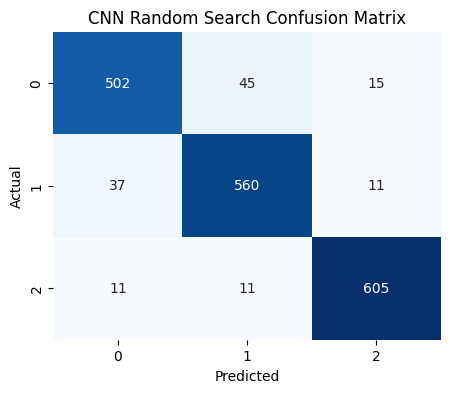


----------------------------------------



In [13]:
y_pred_rs = best_model_random.predict(test_generator)
y_pred_rs = np.argmax(y_pred_rs, axis=1)

cm_rs = confusion_matrix(test_generator.classes, y_pred_rs)

print("==== CNN Random Search ====")
print(f"Accuracy: {accuracy_score(test_generator.classes, y_pred_rs):.4f}")
print(f"Precision: {precision_score(test_generator.classes, y_pred_rs, average='weighted'):.4f}")
print(f"Recall: {recall_score(test_generator.classes, y_pred_rs, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(test_generator.classes, y_pred_rs, average='weighted'):.4f}")

print("\n" + "-"*40 + "\n")

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rs, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CNN Random Search Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n" + "-"*40 + "\n")

## Konversi Model

In [29]:
saved_model_path = 'saved_model/'
mobilenet.export(saved_model_path)

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137111761403152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137111761387792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137111761402960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137111761387600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137111761402192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137111761392592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137108388634576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137108388632656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137108388629584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137108388635152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13710838862747

In [1]:
# Melakukan konversi model saved_model ke tfjs
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/tfjs_model

2025-11-16 03:03:36.719900: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 03:03:37.311218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763262217.583875   25635 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763262217.644739   25635 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763262217.853473   25635 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [12]:
# Melakukan konversi model saved_model ke tflite
classes = ['glacier', 'sea', 'street']
os.makedirs("tflite", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

with tf.io.gfile.GFile('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

with open("tflite/label.txt", "w") as f:
    for label in classes:
        f.write(label + "\n")

## Inference (Optional)

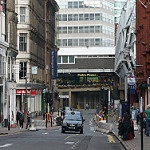

In [27]:
# Percobaan Inference 1
img = Image.open("seg_pred/seg_pred/10012.jpg")
img

In [31]:
img = load_img(f"seg_pred/seg_pred/10012.jpg", target_size=(128,128))

img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255

saved_model = tf.keras.layers.TFSMLayer(saved_model_path, call_endpoint='serving_default')
prediction = saved_model(img)

print(prediction)

class_prediction = classes[np.argmax(prediction['output_0'].numpy()[0])]

print(f"\nHasil Prediksi: {class_prediction}")

{'output_0': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6.6596456e-08, 1.0545489e-09, 9.9999988e-01]], dtype=float32)>}

Hasil Prediksi: street


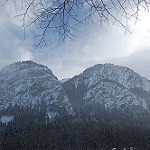

In [33]:
# Percobaan Inference 2
img = Image.open("seg_pred/seg_pred/10013.jpg")
img

In [34]:
img = load_img(f"seg_pred/seg_pred/10013.jpg", target_size=(128,128))

img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255

saved_model = tf.keras.layers.TFSMLayer(saved_model_path, call_endpoint='serving_default')
prediction = saved_model(img)

print(prediction)

class_prediction = classes[np.argmax(prediction['output_0'].numpy()[0])]

print(f"\nHasil Prediksi: {class_prediction}")

{'output_0': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[9.9869102e-01, 1.2675262e-03, 4.1428844e-05]], dtype=float32)>}

Hasil Prediksi: glacier


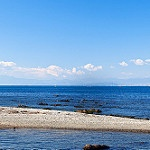

In [37]:
# Percobaan Inference 3
img = Image.open("seg_pred/seg_pred/1003.jpg")
img

In [38]:
img = load_img(f"seg_pred/seg_pred/1003.jpg", target_size=(128,128))

img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255

saved_model = tf.keras.layers.TFSMLayer(saved_model_path, call_endpoint='serving_default')
prediction = saved_model(img)

print(prediction)

class_prediction = classes[np.argmax(prediction['output_0'].numpy()[0])]

print(f"\nHasil Prediksi: {class_prediction}")

{'output_0': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.5277135e-03, 9.9841809e-01, 5.4102569e-05]], dtype=float32)>}

Hasil Prediksi: sea
